In [1]:
import math
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
dicom_file_path = 'images/DICOMOBJ/MTF'
H, W = (600, 1000), (200, 1000)

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array[H[0]: H[1], W[0]: W[1]] # crop aspect
h, w = arr.shape
h, w

(400, 800)

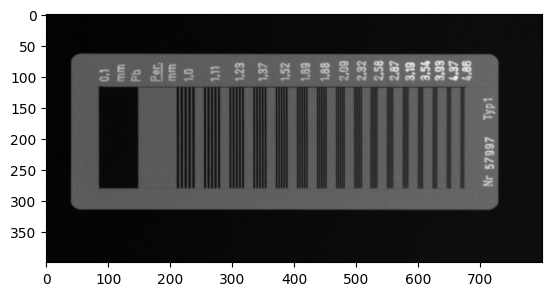

In [3]:
display(arr, True)

In [4]:
hp = int(0.26*h)
wp = int(0.02*w)

In [5]:
focus_l = arr[h-2*hp: , wp*9: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(208, 32)

In [6]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by row
    Return: argdiff in len(rows)
    """
    nrows, ncols = arr.shape
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [7]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

123

In [8]:
focus_r = arr[h-2*hp: , w-(wp*11): w-(wp*9)]
nrows, ncols = focus_r.shape
nrows, ncols

(208, 32)

In [9]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

123

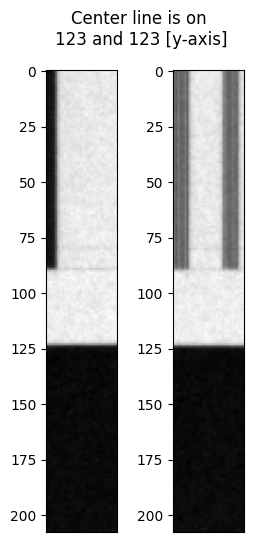

In [10]:
plt.figure(figsize=(3, 6))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [11]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.asin(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [12]:
theta = find_theta(w, y1, y2)
theta

0.0

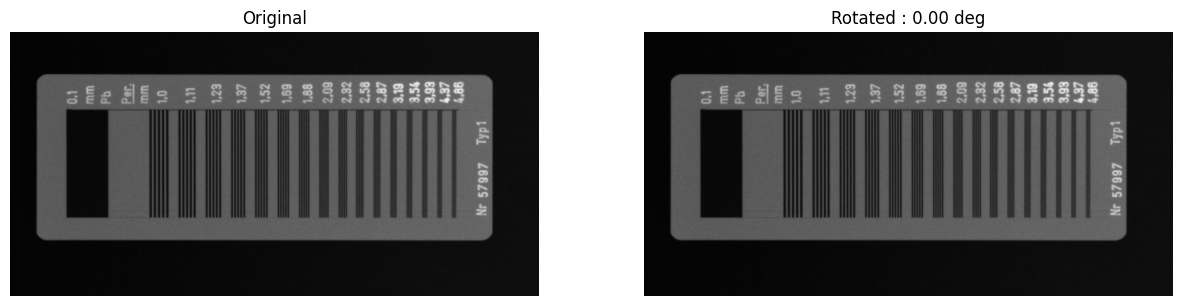

In [13]:
rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [14]:
h, w = rotate_img.shape
h, w

(400, 800)

In [15]:
hp = int(0.11*h)
wp = int(0.06*w)

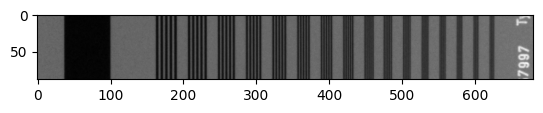

In [16]:
focus = rotate_img[h//2-hp: h//2+hp, wp: w-int(wp*1.5)]
display(focus, True)

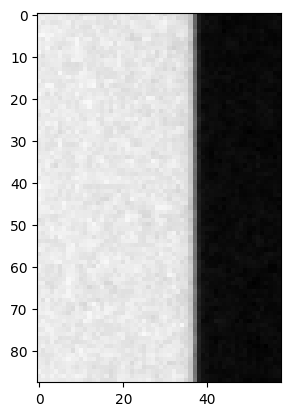

In [17]:
wpf = int(0.086*focus.shape[1])
display(focus[:, :wpf], True)

In [18]:
black = round(np.min(focus[:, (wpf//3)*2:wpf]))
white = max(round(np.min(focus[:, :wpf//3])), black) # white is white not black : in case black include min value
white, black

(1615, 772)

In [19]:
mean_max_vals0, mean_min_vals0 = round(max(np.mean(focus[:, :wpf//3]), np.mean(focus[:, (wpf//3)*2:wpf]))), round(np.mean(focus[:, (wpf//3)*2:wpf]))
max_ref = abs(mean_max_vals0 - mean_min_vals0)
max_ref

871

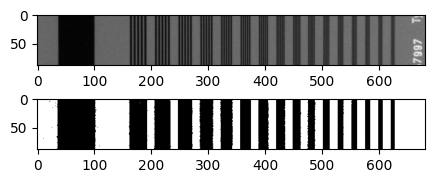

In [20]:
threshold = white
binary_image = np.where(focus <= threshold, 0, 1)

plt.figure(figsize=(5, 2))
plt.subplot(2, 1, 1)
display(focus, True)

plt.subplot(2, 1, 2)
display(binary_image, True)

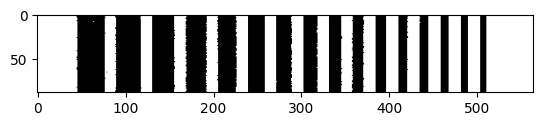

In [21]:
# find position to determined line pairs
linepairs = binary_image[:, wpf*2:]
display(linepairs, True)

In [22]:
locate = np.median(linepairs, axis=0)
locate[:200]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])

In [23]:
arg_locates = []
s1, s2 = None, None
find_start = True # find first zero to determined area
for idx, val in enumerate(locate) :
    if find_start :
        if val == 0.0 :
            s1 = idx
            find_start = False
            arg_locates.append(s1)
    else :
        if val == 1.0 :
            find_start = True
            s2 = idx 
            arg_locates.append(s2)

In [24]:
npairs = 16
trim = int(0.004*len(locate))
pairs = [(arg_locates[i]+trim, arg_locates[i + 1]-trim) for i in range(0, len(arg_locates) - 1, 2)][:npairs]
pairs

[(48, 75),
 (92, 116),
 (133, 154),
 (171, 191),
 (208, 225),
 (242, 257),
 (274, 288),
 (305, 317),
 (334, 344),
 (361, 369),
 (387, 395),
 (413, 419),
 (437, 443),
 (461, 466),
 (484, 488),
 (506, 509)]

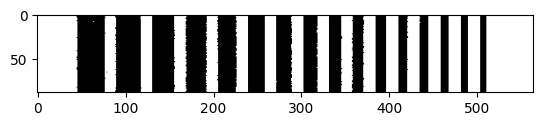

In [25]:
display(linepairs, True)

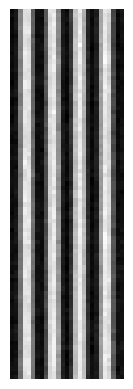

In [26]:
focus = focus[:, wpf*2:]
display(focus[:, pairs[0][0]: pairs[0][1]])

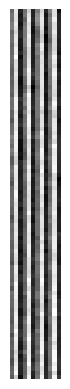

In [27]:
display(focus[:, pairs[7][0]: pairs[7][1]])

In [28]:
res = {"Linepair": [0], "Max": [mean_max_vals0], "Min": [mean_min_vals0], "Contrast": [max_ref], "Modulation": [100]}
for idx, (s1, s2) in enumerate(pairs, start=1) :
    linepair = focus[:, s1: s2]
    mean_val_col = np.mean(linepair, axis=0)
    sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    mid_pos = max(min((s2-s1)//2, int(.3*(s2-s1))), 1) # how to select actual value, 1 if 0
    mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    contrast = mean_max_vals-mean_min_vals
    res["Linepair"].append(idx)
    res["Max"].append(mean_max_vals)
    res["Min"].append(mean_min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round((mean_max_vals-mean_min_vals)*100/max_ref, 3))
res = pd.DataFrame(res)

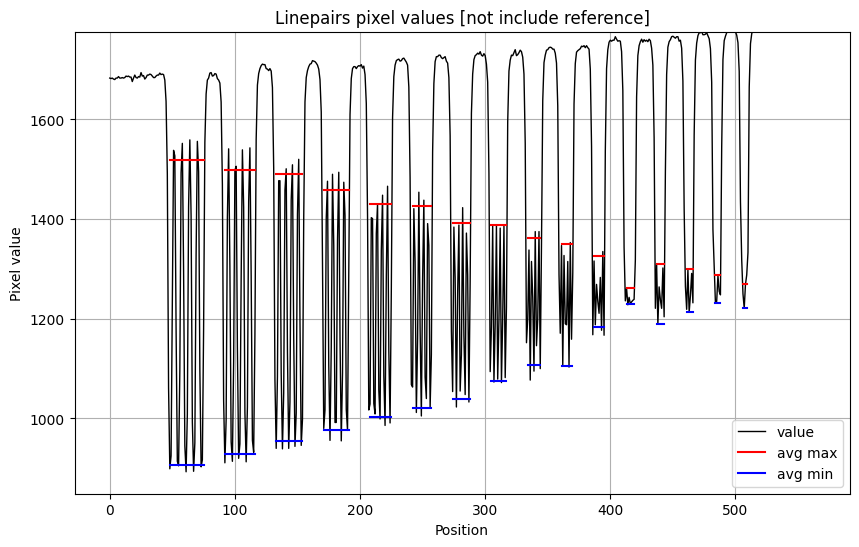

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(np.mean(focus, axis=0, dtype=np.int32), color="black", linewidth=1)
for (s1, s2), (_, max_v, min_v, _, _) in zip(pairs, res.values[1:]) :
    plt.plot([s1, s2], [max_v, max_v], color="red")
    plt.plot([s1, s2], [min_v, min_v], color="blue")
plt.ylim(black+int(black*.1), white+int(white*.1))
plt.legend(["value", "avg max", "avg min"])
plt.grid(True)
plt.title("Linepairs pixel values [not include reference]")
plt.ylabel("Pixel value")
plt.xlabel("Position");

In [30]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,1687,816,871,100.000
1,1,1519,907,612,70.264
2,2,1498,928,570,65.442
3,3,1491,954,537,61.653
4,4,1458,976,482,55.339
5,5,1430,1003,427,49.024
6,6,1426,1020,406,46.613
7,7,1392,1040,352,40.413
8,8,1388,1075,313,35.936
9,9,1363,1107,256,29.392


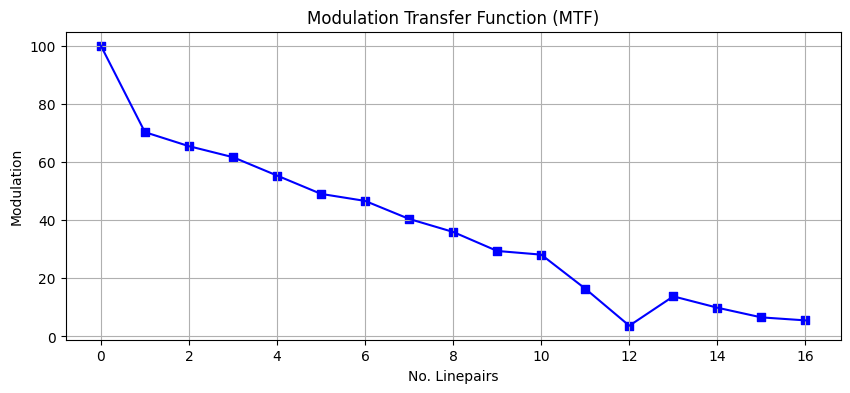

In [31]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");